# Stage 3-  Airbnb Amsterdam  - Feature Engineering 

Now we will enrich the data and will highlight use addition resources to highlight significant insights 

In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import os
#warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import pyodbc

plt.style.use('seaborn')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import datetime

In [28]:
df = pd.read_csv('stage3_airbnb_amsterdam.csv')
df.head()

,Unnamed: 0,id,host_id,host_location,host_response_time,host_is_superhost,host_neighbourhood,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,_'jumio',_'facebook',_'offline_government_id',_'government_id',_'selfie',_'identity_manual',_'work_email',_'google','phone',_'manual_offline'
0,19991,6345018,31857493,Missing,missing,0,missing,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19993,10227700,52558016,Missing,missing,0,missing,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19996,13585881,78399846,Missing,missing,0,missing,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20015,21892378,159732303,Missing,missing,0,missing,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,13824148,79317608,Netherlands,within a few hours,1,missing,1,1,1,...,1,1,0,0,0,0,0,0,0,0


In [29]:
#First we clear the disposable data that commomley appears uppon dataset upload
del  df['Unnamed: 0']

# Interctive Map of Listings in Amsterdam

In [30]:
lats2018 = df['latitude'].tolist()
lons2018 = df['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

### Aggregations


We have been throwing many data tests; in here will summaries the most significant ones.

How many assest hosts manage compeare to superhosts? 

In [9]:
df.groupby('host_is_superhost').agg({'host_total_listings_count':['min',max,'mean']})

host_total_listings_count               
                                        min  max      mean
host_is_superhost                                         
0                                         0  698  6.814591
1                                         0   96  2.329653

Since we didn't delete outliers of this value. we will devide the number of asset into groups

In [10]:
df['ListingsGroup'] = '0-698'
df.loc[df['host_total_listings_count']==1,'ListingsGroup'] = '1'
df.loc[df['host_total_listings_count']==2,'ListingsGroup'] = '2'
df.loc[df['host_total_listings_count']==3,'ListingsGroup'] = '3'
df.loc[df['host_total_listings_count']==4,'ListingsGroup'] = '4'
df.loc[df['host_total_listings_count']==5,'ListingsGroup'] = '5'
df.loc[df['host_total_listings_count']==6,'ListingsGroup'] = '6'
df.loc[df['host_total_listings_count']>=7,'ListingsGroup'] = '7+'
df.loc[df['host_total_listings_count']==0,'ListingsGroup'] = None 
#df['ListingsGroup'].value_counts()

In [11]:
df.groupby(['host_is_superhost','ListingsGroup']).agg(['count',sum,'mean'])['host_total_listings_count']

count    sum       mean
host_is_superhost ListingsGroup                         
0                 1              12998  12998   1.000000
                  2               1895   3790   2.000000
                  3                484   1452   3.000000
                  4                217    868   4.000000
                  5                151    755   5.000000
                  6                142    852   6.000000
                  7+               954  94179  98.720126
1                 1               2131   2131   1.000000
                  2                681   1362   2.000000
                  3                152    456   3.000000
                  4                 46    184   4.000000
                  5                 16     80   5.000000
                  6                 18    108   6.000000
                  7+               123   3064  24.910569

Listings (assets) ownership presentage?


In [12]:
a = df.groupby(['host_is_superhost','ListingsGroup']).agg(['count'])['id']
b= a.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).round(2)
b

count
host_is_superhost ListingsGroup       
0                 1              77.18
                  2              11.25
                  3               2.87
                  4               1.29
                  5               0.90
                  6               0.84
                  7+              5.66
1                 1              67.29
                  2              21.50
                  3               4.80
                  4               1.45
                  5               0.51
                  6               0.57
                  7+              3.88

We see that the presentage of superhosts manging 2 listings is double than the hosts'

### Hosts location

In [13]:
#Host location:
#df.groupby('host_is_superhost').agg('ListingsGroup')
df.groupby(['host_is_superhost','host_location']).agg(['count'])['host_neighbourhood']

count
host_is_superhost host_location        
0                 Africa              9
                  Canada             10
                  Europe            315
                  Far East           13
                  FarEast            27
                  Middle East        24
                  Missing            39
                  Netherlands     16040
                  Oceania            28
                  Other              20
                  South America      19
                  USA               118
                  United Kingdom    198
1                 Africa              1
                  Canada              6
                  Europe             41
                  FarEast             1
                  Middle East         4
                  Missing             1
                  Netherlands      3082
                  Oceania             4
                  South America       1
                  USA                14
                  United Kingdom     15

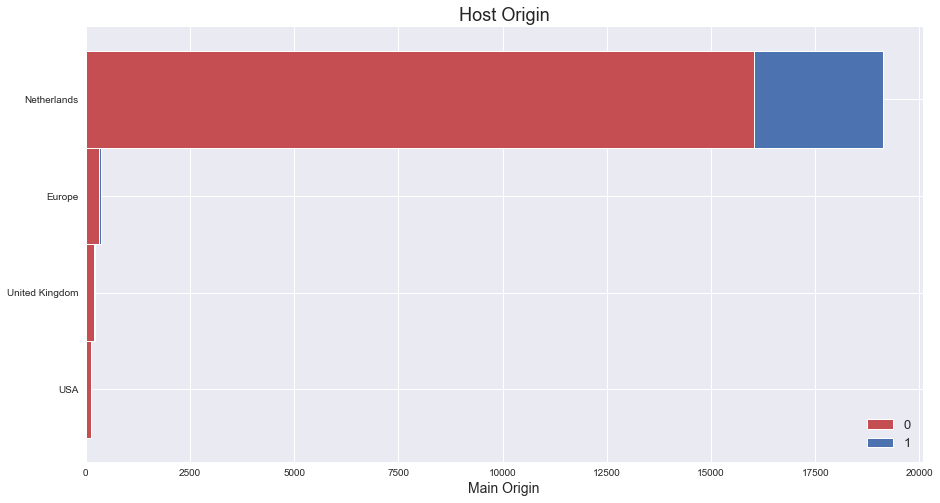

In [14]:
prop = df.groupby(['host_location','host_is_superhost']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Host Origin', fontsize=18)
plt.xlabel('Main Origin', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

A slight leverage to host that are located in the Netherlands 

#### Host and Superhost room_type comparrion 

In [15]:
df.groupby('host_is_superhost').agg({'room_type':['count']})

,room_type
,count
host_is_superhost,
0,16860
1,3170


A segnificant trend for private room for the benefit of the superhost. We assume AirBnB travelres are looking for company

In [16]:
df.groupby(['host_is_superhost','room_type']).agg(['count'])['id']

count
host_is_superhost room_type             
0                 Entire home/apt  13827
                  Private room      2977
                  Shared room         56
1                 Entire home/apt   2062
                  Private room      1099
                  Shared room          9

In [17]:
c = df.groupby(['host_is_superhost','room_type']).agg(['count'])['id']
e= c.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).round(2)
e

count
host_is_superhost room_type             
0                 Entire home/apt  82.01
                  Private room     17.66
                  Shared room       0.33
1                 Entire home/apt  65.05
                  Private room     34.67
                  Shared room       0.28

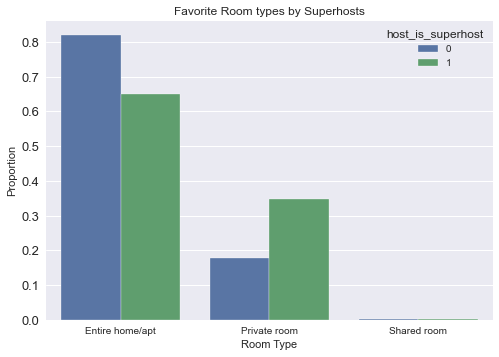

In [18]:
x, y, hue = "room_type", "Proportion", "host_is_superhost"
prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=prop_df)
plt.xticks(rotation=0)
plt.xlabel('Room Type')
plt.title('Favorite Room types by Superhosts')
plt.show()

### Accommodates

Accommodates by the data is number of guests booking. Most booking are for 2 people as expected, with a bit of leverage to superhots.

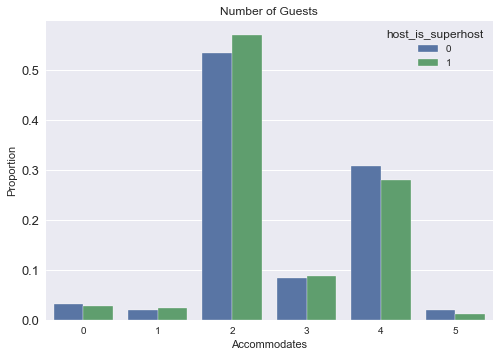

In [19]:
x, y, hue = "accommodates", "Proportion", "host_is_superhost"
prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=prop_df)
plt.xticks(rotation=0)
plt.xlabel('Accommodates')
plt.title('Number of Guests')
plt.show()

Supperhost attend to offer accommodates for 2 people - relativly more than other hosts

### Host Location by neighbourhood

Where do hosts and superhost located?

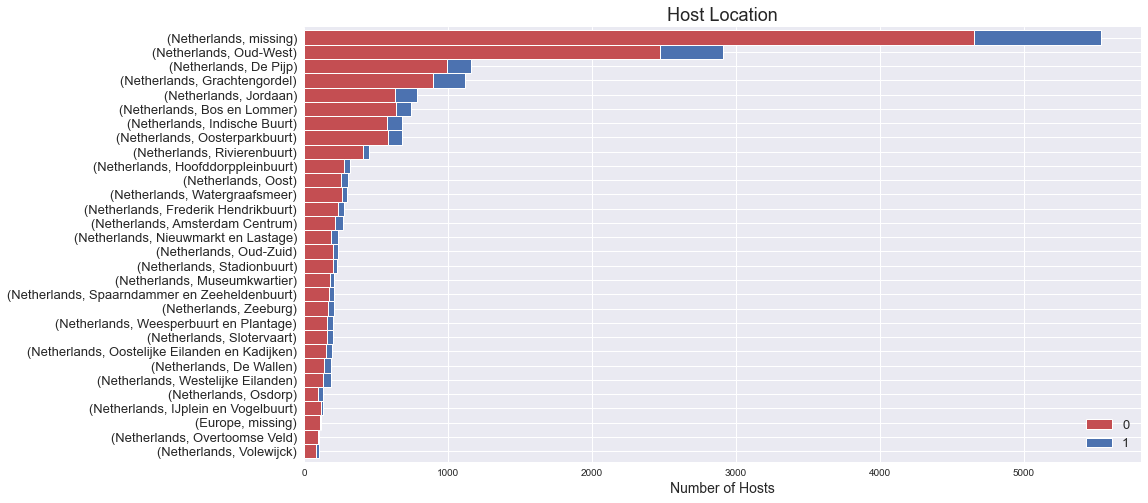

In [20]:
prop = df.groupby(['host_location','host_neighbourhood','host_is_superhost']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Host Location', fontsize=18)
plt.xlabel('Number of Hosts', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

### Average daily price per neighbourhood¶

In order to compare "apples to apples" I have only selected the most common type of accommodation, which is accommodation for 2 persons. As expected, accommodation in the city centre is the most expensive.

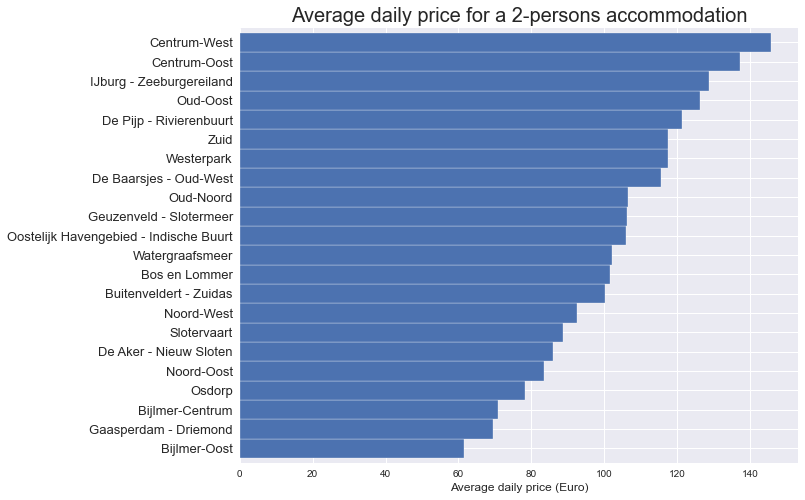

In [21]:
feq = df[df['accommodates']==2]
feq = feq.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

### Superhost Pricing

The pricing is very similar between hosts and superhosts 

In [22]:
df.groupby(['host_is_superhost', 'accommodates']).agg({'price':['mean']})

price
                                      mean
host_is_superhost accommodates            
0                 0             341.447706
                  1              71.609329
                  2             118.658320
                  3             136.382311
                  4             196.884601
                  5             211.089286
1                 0             357.595506
                  1              59.197368
                  2             118.504978
                  3             141.043478
                  4             204.242664
                  5             244.285714

### Host avaiabilty

Superhost avaiabilty is higher than host:

In [23]:
df.groupby(['host_is_superhost']).agg(['count', 'mean'])['availability_365']

,count,mean
host_is_superhost,,
0,16860,54.249110
1,3170,90.041325


### Text

Let's take a look at the textual results coming from reviews

In [24]:
reviews_details = pd.read_csv('reviews_details.csv')
reviews_details.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [25]:
#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [26]:
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

'great time amsterdam daniel excellent host friendly everytime helpful room cozy comfortable clean maps towels mini fridge coffee very tasty tea supplies provided bathroom bathroom requires good location next tram stop took around minutes get city center totally recommendable '

In [27]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
51,great,203591
175,apartment,183343
53,amsterdam,171791
87,stay,164215
3,place,161435
106,us,130859
4,nice,123083
67,location,119437
26,host,102330
5,clean,94514


## A Word Cloud

The following indicates the relation of the words appearance in comments by its size

In [32]:
#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

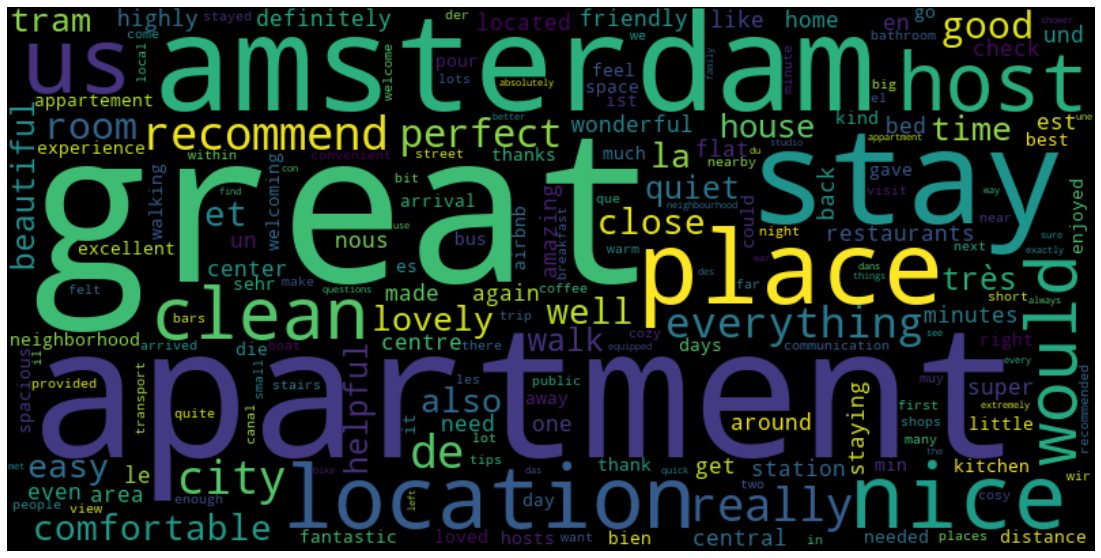

In [33]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [63]:
cvec_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182186 entries, 51 to 182185
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   words   182186 non-null  object
 1   counts  182186 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ MB


In [17]:
#df

Before mooving on to data selection, Let's encode the categorial data.

In [67]:
#list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
#for col in list_str_obj_cols:
#    dencoder=ce.OneHotEncoder(df)#,return_df=True,use_cat_names=True)

#list_str_obj_cols

['host_location',
 'host_response_time',
 'host_neighbourhood',
 'neighbourhood',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'calendar_updated',
 'cancellation_policy',
 'ListingsGroup']

In [68]:
#encoder=ce.OneHotEncoder(list_str_obj_cols,handle_unknown='return_nan',return_df=True,use_cat_names=True)
#list_str_obj_cols

['host_location',
 'host_response_time',
 'host_neighbourhood',
 'neighbourhood',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'calendar_updated',
 'cancellation_policy',
 'ListingsGroup']

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20030 entries, 0 to 20029
Columns: 159 entries, id to ListingsGroup
dtypes: float64(4), int64(144), object(11)
memory usage: 24.3+ MB


In [206]:
!pip install category_encoders
import category_encoders as ce
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import base

In [72]:
df_object =  df.select_dtypes(include = ['object']).columns

In [73]:
from sklearn.preprocessing import OrdinalEncoder

for col in df_object:
  ord_enc = OrdinalEncoder()
  df[[col]] = ord_enc.fit_transform(df[[col]])

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20030 entries, 0 to 20029
Columns: 159 entries, id to ListingsGroup
dtypes: float64(15), int64(144)
memory usage: 24.3 MB


In [25]:
#temp= df.copy()
#label=df.copy()
#for i in  df:
  #  if(df[i].dtype=='object'):
  #      df[i]=label.fit_transform(df[i])
   # else:
  #      df[i]=df[i]

In [26]:
#df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20030 entries, 0 to 20029
Columns: 159 entries, id to ListingsGroup
dtypes: float64(15), int64(144)
memory usage: 24.3 MB


In [75]:
df.to_csv('stage4_amsterdam_feature_selection.csv')

# Next to Feature Selection